<a href="https://colab.research.google.com/github/bm23abb/7PAM2002-0509-2023---Data-Science-Project/blob/main/7PAM2002_0509_2023_Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import BayesianRidge
from tabulate import tabulate

In [5]:
file_path = '/content/drive/MyDrive/7PAM2002-0509-2023-Data-Science-Project/Data-Science-Project/Bitcoin.csv'
data_frame = pd.read_csv(file_path)

In [6]:
print("First few rows of the dataset:")
print(tabulate(data_frame.tail(), headers='keys', tablefmt='grid'))

First few rows of the dataset:
+------+------------+---------+---------+---------+---------+-------------+-------------+
|      | Date       |    Open |    High |     Low |   Close |   Adj Close |      Volume |
+======+============+=========+=========+=========+=========+=============+=============+
| 2678 | 2022-01-16 | 43172   | 43436.8 | 42691   | 43113.9 |     43113.9 | 17902097845 |
+------+------------+---------+---------+---------+---------+-------------+-------------+
| 2679 | 2022-01-17 | 43118.1 | 43179.4 | 41680.3 | 42250.6 |     42250.6 | 21690904261 |
+------+------------+---------+---------+---------+---------+-------------+-------------+
| 2680 | 2022-01-18 | 42250.1 | 42534.4 | 41392.2 | 42375.6 |     42375.6 | 22417209227 |
+------+------------+---------+---------+---------+---------+-------------+-------------+
| 2681 | 2022-01-19 | 42374   | 42478.3 | 41242.9 | 41744.3 |     41744.3 | 23091543258 |
+------+------------+---------+---------+---------+---------+--------

In [7]:
data_frame['Date'] = pd.to_datetime(data_frame['Date'])
data_frame.set_index('Date', inplace=True)
data_frame = data_frame.sort_values('Date')
data_frame = data_frame.fillna(method='ffill')
data_frame['Year'] = data_frame.index.year
data_frame['Month'] = data_frame.index.month
data_frame['Day'] = data_frame.index.day
data_frame['DayOfWeek'] = data_frame.index.dayofweek

pforp = data_frame['Close'].values.reshape(-1,1)

In [8]:
print("First few rows of the preprocessed dataset:")
print(tabulate(data_frame.tail(), headers='keys', tablefmt='grid'))

First few rows of the preprocessed dataset:
+---------------------+---------+---------+---------+---------+-------------+-------------+--------+---------+-------+-------------+
| Date                |    Open |    High |     Low |   Close |   Adj Close |      Volume |   Year |   Month |   Day |   DayOfWeek |
+=====================+=========+=========+=========+=========+=============+=============+========+=========+=======+=============+
| 2022-01-16 00:00:00 | 43172   | 43436.8 | 42691   | 43113.9 |     43113.9 | 1.79021e+10 |   2022 |       1 |    16 |           6 |
+---------------------+---------+---------+---------+---------+-------------+-------------+--------+---------+-------+-------------+
| 2022-01-17 00:00:00 | 43118.1 | 43179.4 | 41680.3 | 42250.6 |     42250.6 | 2.16909e+10 |   2022 |       1 |    17 |           0 |
+---------------------+---------+---------+---------+---------+-------------+-------------+--------+---------+-------+-------------+
| 2022-01-18 00:00:00 | 4

In [9]:
normalize = MinMaxScaler(feature_range=(0 ,1))
normalize_price = normalize.fit_transform(pforp)

In [10]:
n_p_df = pd.DataFrame(normalize_price, columns=['Normalize close'])
print("First few rows of Min-Max Normalize prices:")
print(tabulate(n_p_df.head(), headers='keys', tablefmt="grid"))

First few rows of Min-Max Normalize prices:
+----+-------------------+
|    |   Normalize close |
+====+===================+
|  0 |        0.00414359 |
+----+-------------------+
|  1 |        0.00365546 |
+----+-------------------+
|  2 |        0.00321557 |
+----+-------------------+
|  3 |        0.00342492 |
+----+-------------------+
|  4 |        0.0032753  |
+----+-------------------+


In [11]:
def create_datset(dataset, look_back=60):
  x, y = [], []
  for i in range(len(dataset) - look_back - 1):
    a = dataset[i:(i + look_back), 0]
    x.append(a)
    y.append(dataset[i + look_back, 0])
  return np.array(x), np.array(y)

look_back = 60
x, y = create_datset(normalize_price, look_back)
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [12]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

2097/2097 [==============================] - 41s 16ms/step - loss: 1.8404e-04


In [32]:
future_date = 7
future_input = normalize_price[-look_back:]
future_predict_lstm = []
for _ in range(future_date):
    future_input_reshaped = np.reshape(future_input, (1, look_back, 1))
    future_predict = model.predict(future_input_reshaped)
    future_predict_lstm.append(future_predict[0, 0])
    future_input = np.append(future_input[1:], future_predict)

future_predict_lstm = normalize.inverse_transform(np.array(future_predict_lstm).reshape(-1, 1))

future_dates = pd.date_range(start=data_frame.index[-1] + pd.DateOffset(days=1), periods=future_date, freq='D')


1/1 [==============================] - 0s 42ms/step


In [34]:
lstm_predict_df = pd.DataFrame({
        'Date': future_dates,
        'LSTM_Prediction': future_predict_lstm.flatten()
    })
print("LSTM Predictions for the next '7' days:")
print(tabulate(lstm_predict_df, headers='keys', tablefmt='grid'))

LSTM Predictions for the next '7' days:
+----+---------------------+-------------------+
|    | Date                |   LSTM_Prediction |
+====+=====================+===================+
|  0 | 2022-01-21 00:00:00 |           38608.9 |
+----+---------------------+-------------------+
|  1 | 2022-01-22 00:00:00 |           37683.5 |
+----+---------------------+-------------------+
|  2 | 2022-01-23 00:00:00 |           36527.9 |
+----+---------------------+-------------------+
|  3 | 2022-01-24 00:00:00 |           35281.5 |
+----+---------------------+-------------------+
|  4 | 2022-01-25 00:00:00 |           34015.2 |
+----+---------------------+-------------------+
|  5 | 2022-01-26 00:00:00 |           32766.8 |
+----+---------------------+-------------------+
|  6 | 2022-01-27 00:00:00 |           31557.9 |
+----+---------------------+-------------------+


In [35]:
arima_model = ARIMA(pforp, order=(5, 1, 0))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=future_date).reshape(-1, 1)

In [41]:
arime_predict_df = pd.DataFrame({
        'Date': future_dates,
         'ARIMA_Predictions':arima_forecast.flatten()
    })
print("ARIMA Predictions for the next '7' days:")
print(tabulate(arime_predict_df, headers='keys', tablefmt='grid'))

ARIMA Predictions for the next '7' days:
+----+---------------------+---------------------+
|    | Date                |   ARIMA_Predictions |
+====+=====================+=====================+
|  0 | 2022-01-21 00:00:00 |             41880.9 |
+----+---------------------+---------------------+
|  1 | 2022-01-22 00:00:00 |             41861.5 |
+----+---------------------+---------------------+
|  2 | 2022-01-23 00:00:00 |             41835.8 |
+----+---------------------+---------------------+
|  3 | 2022-01-24 00:00:00 |             41829.3 |
+----+---------------------+---------------------+
|  4 | 2022-01-25 00:00:00 |             41831.4 |
+----+---------------------+---------------------+
|  5 | 2022-01-26 00:00:00 |             41828.7 |
+----+---------------------+---------------------+
|  6 | 2022-01-27 00:00:00 |             41827   |
+----+---------------------+---------------------+


In [39]:
bayesian_model = BayesianRidge()
bayesian_model.fit(np.arange(len(pforp)).reshape(-1, 1), pforp.flatten())
future_in = np.arange(len(pforp), len(pforp) + future_date).reshape(-1, 1)
bayesian_forcest = bayesian_model.predict(future_in).reshape(-1, 1)

In [40]:
bayesian_predict_df = pd.DataFrame({
        'Date': future_dates,
        'BayesianRidge_Prediction': bayesian_forcest.flatten()
    })
print("BayesianRidge Predictions for the next '7' days:")
print(tabulate(bayesian_predict_df, headers='keys', tablefmt='grid'))

BayesianRidge Predictions for the next '7' days:
+----+---------------------+----------------------------+
|    | Date                |   BayesianRidge_Prediction |
+====+=====================+============================+
|  0 | 2022-01-21 00:00:00 |                    31708.9 |
+----+---------------------+----------------------------+
|  1 | 2022-01-22 00:00:00 |                    31724.3 |
+----+---------------------+----------------------------+
|  2 | 2022-01-23 00:00:00 |                    31739.7 |
+----+---------------------+----------------------------+
|  3 | 2022-01-24 00:00:00 |                    31755.2 |
+----+---------------------+----------------------------+
|  4 | 2022-01-25 00:00:00 |                    31770.6 |
+----+---------------------+----------------------------+
|  5 | 2022-01-26 00:00:00 |                    31786   |
+----+---------------------+----------------------------+
|  6 | 2022-01-27 00:00:00 |                    31801.5 |
+----+-----------------

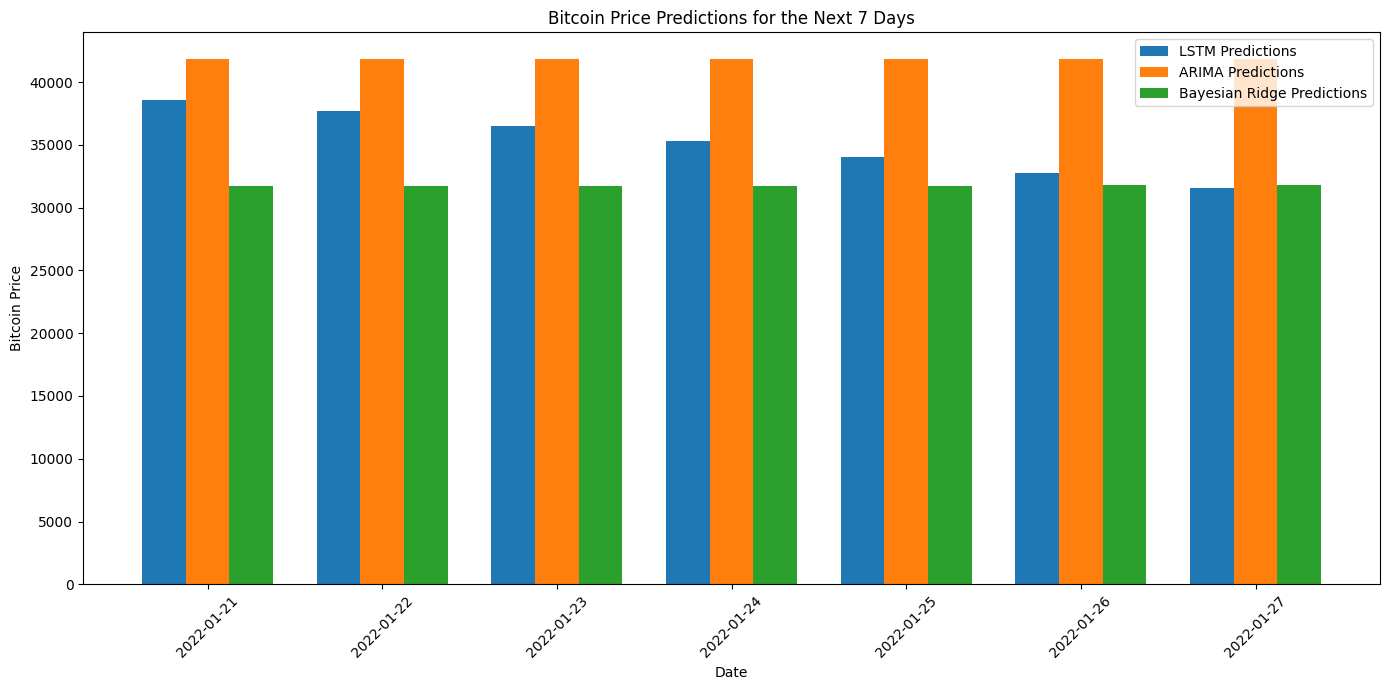

In [44]:
plt.figure(figsize=(14, 7))

bar_width = 0.25
index = np.arange(len(future_dates))

# Bar plot for LSTM predictions
plt.bar(index, future_predict_lstm.flatten(), bar_width, label='LSTM Predictions')

# Bar plot for ARIMA predictions
plt.bar(index + bar_width, arima_forecast.flatten(), bar_width, label='ARIMA Predictions')

# Bar plot for Bayesian Ridge predictions
plt.bar(index + 2 * bar_width, bayesian_forcest.flatten(), bar_width, label='Bayesian Ridge Predictions')

# Plot settings
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Predictions for the Next 7 Days')
plt.xticks(index + bar_width, future_dates.strftime('%Y-%m-%d'), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
